In [1]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./funlopt/funl_dynamics.jl")
include("./funlopt/funl_utils.jl")
include("./funlopt/funl_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [2]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/nominal_traj_unicycle_0324" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"];
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [3]:
ix = 3
iu = 2
iϕ = 2
iv = 2
iψ = iϕ*iv
iμ = iψ
@assert size(xnom,2) - 1 == N

In [4]:
Go = [1 2;1 2;0 0]
G = kron(Go,ones(1,iv))
Cv = [0 0 1;0 0 0] 
Dvu = [0 0;1 0]

2×2 Matrix{Int64}:
 0  0
 1  0

In [5]:
dynamics = Unicycle()
alpha = 0.7
DLMI = LinearQS(alpha,ix,iu)

LinearQS(0.7, 3, 2, 9, 4, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1])

In [6]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    ObstacleAvoidance(H_list[1],c_list[1]),
    ObstacleAvoidance(H_list[2],c_list[2])
    ]

6-element Vector{FunnelConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2])
 ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])

In [7]:
Qnom = zeros(ix,ix,N+1)
Snom = zeros(iu,iu,N+1)
Znom = zeros(ix,ix,N+1);
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [8]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0)

In [9]:
include("./funlopt/funl_synthesis.jl")

run (generic function with 1 method)

In [10]:
max_iter = 1;
w_funl = 1.0;
w_vc = 1e2;
w_tr::Float64 = 0.0;
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = true;

In [11]:
fs = FunnelSynthesis(N,max_iter,dynamics,DLMI,list_const,scaler,w_funl,w_vc,w_tr,tol_tr,tol_vc,tol_dyn,verbosity)

FunnelSynthesis(Unicycle(3, 2), LinearQS(0.7, 3, 2, 9, 4, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), FunnelConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [1, 2]), ObstacleAvoidance([2.0 0.0; 0.0 2.0], [4, 3])], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0), FunnelSolution([0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; … ;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; … ;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 

In [12]:
run(fs,Qnom,Snom,Znom,Qini,Qf,xnom,unom,dtnom,"Mosek")

+--------------------------------------------------------------------------------------------------+
|                                   ..:: Penalized Trust Region ::..                               |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
| iter. |    cost    |    tof    |   funl    |   rate    |  param  | log(vc) | log(tr)  | log(dyn) |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+
|1      |-1.93       |-1.000    |-1.928     |-1.000     |-1.000    |-Inf     | 1.8      |-7.5e+00   |


In [13]:
tprop,xprop,uprop = fs.solution.tprop,fs.solution.xprop,fs.solution.uprop
Qprop,Sprop = fs.solution.Qprop,fs.solution.Yprop

([3.2438384979455446 -2.1223476072203233 1.6556188995036238; -2.1223476072203233 3.818546171138506 -2.5795784259997183; 1.6556188995036236 -2.5795784259997183 2.6387340002346145;;; 3.257283325162896 -2.132823751786386 1.6810070641305221; -2.132823751786386 3.807051894428008 -2.5838649971179586; 1.6810070641118695 -2.5838649971180803 2.621480691155556;;; 3.281641808730003 -2.145454232565646 1.7314811960710852; -2.145454232565646 3.7601718395173083 -2.5818011758567407; 1.7314811960248244 -2.581801175857593 2.5920934500935577;;; … ;;; 0.11931419863841894 0.003311362623713253 -0.024338634238605827; 0.003311362623713246 0.07402327002020653 -0.012018047651266616; -0.024338634119903464 -0.012018047632404247 0.1514536713008444;;; 0.09936158885755687 0.0007774727781997711 -0.010890231354339386; 0.0007774727781997637 0.07631835147903418 -0.004289048246303262; -0.0108902312535847 -0.004289048227943309 0.10757321251622282;;; 0.0799999958352509 7.988858990442542e-8 -1.0221420185459341e-7; 7.9888589

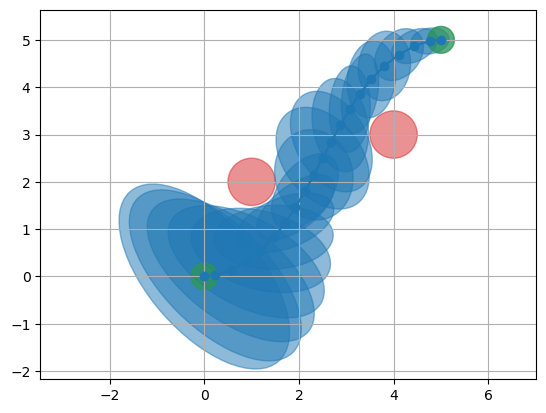

In [14]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(fs.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(fs.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(fs.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = xnom[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([xnom[:,1],xnom[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(xnom[1,:],xnom[2,:],"o-",color="tab:blue")
# ax.plot(ptr.solution.xprop[1,:],ptr.solution.xprop[2,:],"-",color="tab:blue")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [15]:
min_lam_q = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

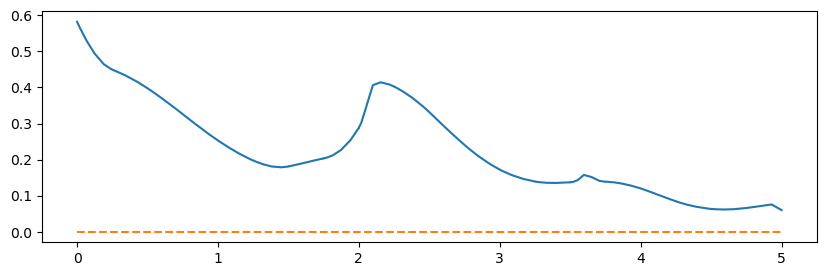

In [16]:
plt.figure(figsize=(10,3))
plt.plot(tprop,min_lam_q)
plt.plot(tprop,tprop*0,"--")
gcf()

In [17]:
findfirst(x -> x < 0, min_lam_q)

In [18]:
min_lam_q[99]

0.10371483699560556

In [19]:
function project_onto_input(Q,S,xnom,unom) 
    R = []
    for i in 1:size(Q,3)
        A,B = diff(dynamics,xnom[:,i],unom[:,i])
        Y = -0.5*S[:,:,i]*B'
        K = Y * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [20]:
input_proj_funl_prop = project_onto_input(Qprop,Sprop,xprop,uprop)
input_proj_funl_nom = project_onto_input(fs.solution.Q,fs.solution.Y,xnom,unom)

2-element Vector{Any}:
 Any[0.5831410022552088, 0.7055147355795252, 0.5437037947344645, 0.4594723511736512, 0.41981834540052126, 0.4396054919750278, 0.4490445806921254, 0.4276344827245536, 0.4177404934335766, 0.41361156250539444  …  0.41363048275631437, 0.41777319232115445, 0.4276657058062416, 0.4490388217942416, 0.4393141484516769, 0.41843135513461405, 0.457772041056227, 0.5431408382536264, 0.7068065275975399, 0.5825668151714395]
 Any[1.4157124053337289, 1.0115135181093755, 1.2281828044990604, 1.3895316320377096, 1.4832307044232549, 1.54665675994476, 1.6731615249030498, 1.7878772472197675, 1.873677464321045, 1.9412161960929777  …  1.9412966575106314, 1.8738230472669282, 1.7881426377633158, 1.6735621060219186, 1.5470426447316998, 1.4835014569015013, 1.3883801968758647, 1.2252534839228626, 1.0071150244093405, 1.4286344628808292]

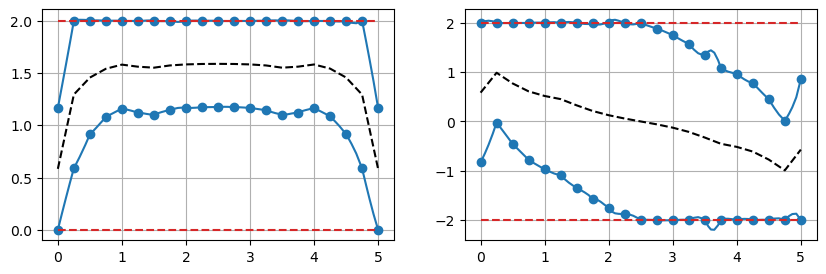

In [21]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,unom[1,:],"--",color="black")
plt.plot(tnom,unom[1,:]+input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tnom,unom[1,:]-input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,unom[2,:],"--",color="black")
plt.plot(tnom,unom[2,:]+input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tnom,unom[2,:]-input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()